In [71]:
%matplotlib inline

import pandas as pd
import numpy as np

import os

from sklearn.preprocessing import LabelEncoder

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error

from scipy.spatial.distance import minkowski, euclidean, cosine

from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(1243)

In [2]:
DATA_DIR = '../data/raw/'

In [92]:
train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'test-comb.csv'))
sample_sub = pd.read_csv(os.path.join(DATA_DIR, 'Sample_Submission_Tm9Lura.csv'))

In [93]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [94]:
test.head()

,Unnamed: 0,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Comb
0,0,1000004,P00128942,M,46-50,7,B,2,0,1,11.0,NaN,1000004P00128942
1,1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN,1000009P00113442
2,2,1000010,P00288442,F,36-45,1,B,4+,0,5,14.0,NaN,1000010P00288442
3,3,1000010,P00145342,F,36-45,1,B,4+,0,4,9.0,NaN,1000010P00145342
4,4,1000011,P00053842,F,26-35,1,C,1,0,4,5.0,12.0,1000011P00053842


### Frequency count of users

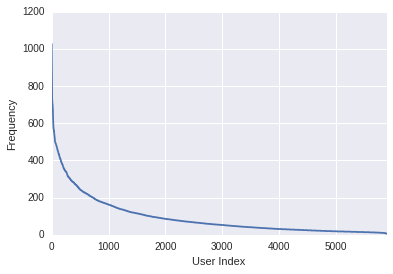

In [95]:
train.User_ID.value_counts().reset_index()['User_ID'].plot()
plt.xlabel('User Index')
plt.ylabel('Frequency');

### Frequency count of products

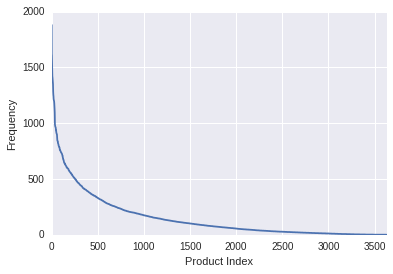

In [96]:
train.Product_ID.value_counts().reset_index()['Product_ID'].plot()
plt.xlabel('Product Index')
plt.ylabel('Frequency');

### Frequency of Purchase Amount

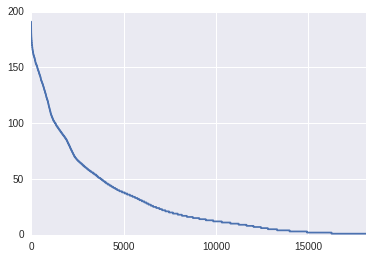

In [97]:
train.Purchase.value_counts().reset_index()['Purchase'].plot();

In [98]:
common_users = np.intersect1d(train.User_ID, test.User_ID)
print('Count of users both in train and test set', len(common_users))
print('User Ids both in train and test set ', common_users)

Count of users both in train and test set 5891
User Ids both in train and test set  [1000001 1000002 1000003 ..., 1006038 1006039 1006040]


In [10]:
common_products = np.intersect1d(train.Product_ID, test.Product_ID)
print('Count of products both in train and test set', len(common_products))
print('Product Ids both in train and test set ', common_products)

Count of products both in train and test set 3445
Product Ids both in train and test set  ['P00000142' 'P00000242' 'P00000342' ..., 'P0099742' 'P0099842' 'P0099942']


In [11]:
# check to see if user id and product id pair is present in test set as well

def f(arrA, arrB):
    return not set(map(tuple, arrA)).isdisjoint(set(map(tuple, arrB)))

f(train[['User_ID', 'Product_ID']].values, test[['User_ID', 'Product_ID']].values)

False

### Convert Categorical attributes to numerical attributes

In [72]:
def encode_categorical_to_numerical(train, test):
    
    train_ = train.copy()
    test_ = test.copy()
    
    encoders_train = {}
    encoders_test = {}
    
    for column in train.columns[:-1]:
        if train[column].dtype == np.object:
            lbl = LabelEncoder()
            encoders_train[column] = lbl.fit_transform(train[column])
            train_[column] = lbl.transform(train[column])
            
            lbl = LabelEncoder()
            encoders_test[column] = lbl.fit_transform(test[column])
            test_[column] = lbl.transform(test[column])
    
    return train_, test_, encoders_train, encoders_test

In [99]:
train_, test_, encoders_train, encoders_test = encode_categorical_to_numerical(train, test)

### Split into training and test set

In [100]:
X_train, X_test, y_train, y_test = train_test_split(train_, train_.Purchase, test_size=0.2, random_state=44)

### Cross validation

In [46]:
def rmse(y_true, y_preds):
    return np.sqrt(mean_squared_error(y_true, y_preds))

rmse_scorer = make_scorer(rmse, greater_is_better=False) # make a custom scorer function.

def calculate_cv(X_train, X_test, y_train, y_test, est, calculate=False):
    
    """
    Takes in training and test set and calculates cv score based on KFold Cross validation
    We can force the function to calculate performance on unseen examples as well.
    """
    
    kfold = KFold(len(y_train), n_folds=3, shuffle=True, random_state=23)
    cv_scores = cross_val_score(est, X_train, y_train, scoring=rmse_scorer, cv=kfold, n_jobs=-1)
    
    if calculate:
        est.fit(X_train, y_train)
        y_preds = est.predict(X_test)
        print('RMSE on unseen examples: %f'%(rmse(y_test, y_preds)))
    
    return cv_scores.mean(), cv_scores.std()

** Dummy Regressor ( Useful as benchmark ) **

In [17]:
# most frequent value is 7011
pred_rmse = np.sqrt(mean_squared_error(y_test, np.array([7011] * len(y_test))))
print('RMSE on unseen examples for strategy=%s is %f'%('constant', pred_rmse))

RMSE on unseen examples for strategy=constant is 5502.848374


In [18]:
# mean purchase amount in the training set is 9263.968712959126
pred_rmse = np.sqrt(mean_squared_error(y_test, np.array([9263.968712959126] * len(y_test))))
print('RMSE on unseen examples for strategy=%s is %f'%('mean', pred_rmse))

RMSE on unseen examples for strategy=mean is 5024.114972


In [19]:
# median purchase amount in the training set is 8047.0
pred_rmse = np.sqrt(mean_squared_error(y_test, np.array([8047.0] * len(y_test))))
print('RMSE on unseen examples for strategy=%s is %f'%('median', pred_rmse))

RMSE on unseen examples for strategy=median is 5167.509877


** Now we can compare our predictions against these basic benchmarks. **

### Distance metrics

Calculate various different distance metrics like euclidean, minkowsky, cosine etc to see if we can use any of the similarity based functions on this dataset or not.

In [77]:
features = ['Gender', 'Age' ,'Occupation', 'Product_Category_1']

In [78]:
X_example = X_test.iloc[10][features].values #random example from the test set

/home/abhishek/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


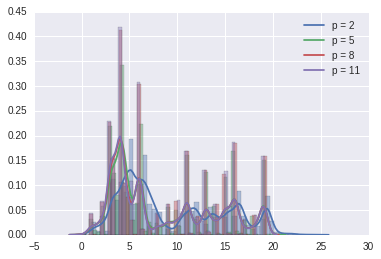

In [79]:
for p in range(2, 12, 3):
    eucld_dists = [minkowski(x, X_example, p) for x in X_train[features].values]
    sns.distplot(eucld_dists, kde_kws={'label': 'p = %s' % p})
plt.show()

/home/abhishek/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


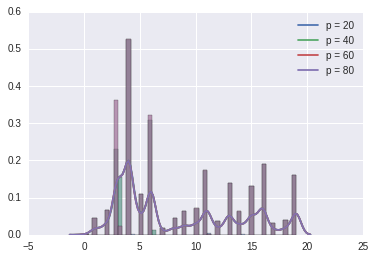

In [80]:
for p in range(20, 100, 20):
    eucld_dists = [minkowski(x, X_example, p) for x in X_train[features].values]
    sns.distplot(eucld_dists, kde_kws={'label': 'p = %s' % p})
plt.show();

### Cosine Distance

/home/abhishek/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


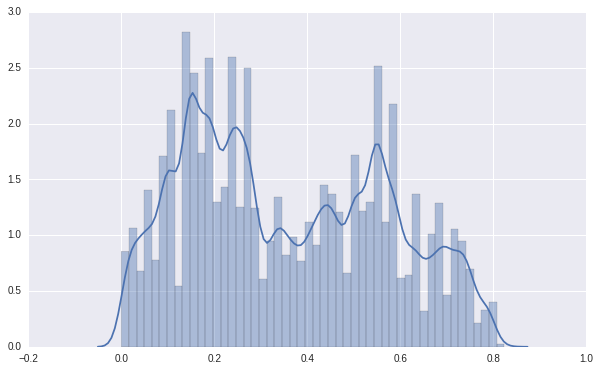

In [81]:
plt.figure(figsize=(10, 6))
cosine_dists = [cosine(x, X_example) for x in X_train[features].values]
sns.distplot(cosine_dists)

### KNeighbors Estimation

In [83]:
def find_optimal_neighbors(X_train, X_test, y_train, y_test):
    best_score = np.inf
    
    for neighbors in [15, 17, 19]:
        knn = KNeighborsRegressor(n_neighbors= neighbors, weights='distance', n_jobs=-1)
        cv_scores_mean, cv_std = calculate_cv(X_train[features].values, X_test[features].values, y_train, y_test, knn)
        
        if abs(cv_scores_mean) < best_score:
            best_score = abs(cv_scores_mean)
            best_num_neighbors = neighbors
    
    return best_score, best_num_neighbors

best_score, num_neighbors = find_optimal_neighbors(X_train, X_test, y_train, y_test)
print('Optimal settings for n_neighbors: %d and mean RMSE score: %f'%(num_neighbors, best_score))

/home/abhishek/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/abhishek/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/abhishek/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes

Optimal settings for n_neighbors: 19 and mean RMSE score: 3081.685702


In [84]:
knn = KNeighborsRegressor(n_neighbors=19, weights='distance', n_jobs=-1)
knn.fit(train[features].values, train.Purchase.values)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=19, p=2,
          weights='distance')

## Submission

In [85]:
preds = knn.predict(test[features].values)

In [101]:
sample_sub['User_ID'] = test.User_ID.values
sample_sub['Product_ID'] = test.Product_ID.values
sample_sub['Purchase'] = preds

In [102]:
sample_sub.to_csv('../submissions/simialrity_based_estimators_19_neighbors.csv', index=False)